In [1186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os.path
import time
import tqdm


from tqdm import notebook
from bitmex import bitmex
from datetime import timedelta, datetime
from dateutil import parser
from stockstats import StockDataFrame as sdf
from pylab import rcParams

In [1738]:
%matplotlib inline
%config InlineBackend.figure_format="retina"

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
plt.rcParams["figure.figsize"]=(20, 20)
plt.rcParams['legend.loc'] = 'upper right'
sns.set_style('ticks')
sns.set_context("notebook", font_scale=1.3)

In [6]:
api_key = '' #get bitmex api key and paste here
api_secret = '' #get bitmex api secret and paste here
client = bitmex(test=False, api_key=api_key, api_secret=api_secret)

binsizes = {"1m": 1, "5m": 5,"1h": 60, "1d": 1440}
batch_size = 750

/home/mneminic/anaconda3/lib/python3.7/site-packages/swagger_spec_validator/validator20.py:53: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  ref_dict['$ref'], '/'.join(path),


In [7]:
def min_data(symbol, kline_size, data):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    else: old = client.Trade.Trade_getBucketed\
        (symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    new = client.Trade.Trade_getBucketed\
    (symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    
    return old, new

In [8]:
def get_all(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = min_data(symbol, kline_size, data_df)
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    rounds = math.ceil(available_data / batch_size)
    if rounds > 0:
        for round_num in tqdm.notebook.tqdm(range(rounds)):
            time.sleep(1)
            new_time = (oldest_point + timedelta(minutes = round_num * batch_size * binsizes[kline_size]))
            data = client.Trade.Trade_getBucketed\
            (symbol=symbol, binSize=kline_size, count=batch_size, startTime = new_time).result()[0]
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
    data_df.set_index('timestamp', inplace=True)
    if save and rounds > 0: data_df.to_csv(filename)

    return data_df

In [9]:
data = get_all("XBTUSD", "5m", save=True)

In [10]:
data_2 = data.copy() 

In [1799]:
data = data_2

In [1800]:
data = data['2018-01-01 00:00:00':]
# make 30 min-period data
data = data.iloc[::6,:]
data.index = data.index.tz_convert(None)

In [1801]:
def make_points(data):
    
    # make 1hour-period data
    stock_1h = data.iloc[::2,:]
    # make macd signal
    stock_1h = sdf.retype(stock_1h)
    stock_1h['macds']
    # identify in peaks
    stock_1h['macdh_increment'] = stock_1h['macdh'].shift(1)
    stock_1h['macdh_decrement'] = stock_1h['macdh'].shift(-1)
    start_points  = stock_1h.loc[(stock_1h['macdh']>0) &\
                          (stock_1h['macdh']> stock_1h['macdh_increment']) &\
                          (stock_1h['macdh']> stock_1h['macdh_decrement'])]
    start_points['macdh_t1'] = start_points['macdh'].shift(1)
    start_points['open_t1'] = start_points['open'].shift(1)
    start_points['close_t1'] = start_points['close'].shift(1)
    # current point - t2, previous in history - t1
    start_points_index = start_points.loc[(start_points['macdh_t1']>=start_points['macdh'])&\
                                      (((start_points['close_t1']>start_points['open_t1'])&\
                                        (start_points['close_t1']*(1-0.0003)<=start_points['high']))|\
                                       ((start_points['close_t1']<=start_points['open_t1'])&\
                                        (start_points['open_t1']*(1-0.0003)<=start_points['high']))
                                      )
                                     ].index
    # make macd signal
    stock = sdf.retype(data)
    stock['macds']
    # identify out peaks
    stock['full_macdh_increment'] = stock['macdh'].shift(1)
    stock['full_macdh_decrement'] = stock['macdh'].shift(-1)
    end_points = stock.loc[(stock['macdh']< stock['full_macdh_increment']) &\
                       (stock['macdh']< stock['full_macdh_decrement']) &\
                       (stock['full_macdh_decrement']<0) & (stock['macdh']<0)]
    end_points['macdh_t1'] = end_points['macdh'].shift(1)
    end_points['open_t1'] = end_points['open'].shift(1)
    end_points['close_t1'] = end_points['close'].shift(1)
    # current point - t2, previous in history - t1
    end_points_true_index =  end_points.loc[(end_points['macdh']>=end_points['macdh_t1'])&\
                                        (((end_points['close_t1']>end_points['open_t1'])&\
                                          (end_points['open_t1']*(1+0.0005)>=end_points['low']))|\
                                         ((end_points['close_t1']<=end_points['open_t1'])&\
                                          (end_points['close_t1']*(1+0.0005)>=end_points['low']))
                                        )
                                       ].index
    
    stock_1h.loc[start_points.index, 'start_points'] = True
    stock_1h.loc[start_points_index, 'start_border'] = True
    stock.loc[end_points.index, 'end_points'] = True
    stock.loc[end_points_true_index, 'true_end_border'] = True
    
    return stock, stock_1h

In [1802]:
stock, stock_1h = make_points(data)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
/home/mneminic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mneminic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/mneminic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is

In [1803]:
def make_true_start_points_and_signal(stock, stock_1h):
    after_start_label = False
    stock['result'] = float('nan')
    stock_1h['result'] = float('nan')
    
    for i in stock.index: 
        
        if i in stock_1h.index:
            if stock_1h.loc[i,'start_border']==True:
                after_start_label = True
            if (after_start_label) and (stock_1h.loc[i,'macdh']<0):
                stock.loc[i + pd.Timedelta('1 hours'), 'result'] = 'BUY'
                stock_1h.loc[i + pd.Timedelta('1 hours'), 'result'] = 'BUY'
                after_start_label = False
            if (stock_1h.loc[i, 'start_points']==True) and\
            (stock_1h.loc[i, 'start_border']!=True):
                after_start_label = False 
        
        if (i not in stock.index[-1:]) and (stock.loc[i, 'true_end_border']==True):
            stock.loc[i + pd.Timedelta('30 min'), 'result'] = 'SELL'
        
    return stock, stock_1h

In [1804]:
stock, stock_1h = make_true_start_points_and_signal(stock, stock_1h)

In [1805]:
def make_deal_data(stock):
    
    deal = []
    date_start = np.nan
    price_start = np.nan
    points = stock.loc[(stock['result']=='BUY')|\
                       (stock['result']=='SELL')]
    
    for i in range(len(points[:-1])):     
        if (points.iloc[i, points.columns.get_loc("result")] == 'BUY') and\
        (points.iloc[i+1, points.columns.get_loc("result")] == 'BUY'):
            date_start = points.iloc[i].name
            price_start = points.iloc[i, points.columns.get_loc("close")]
            
        elif (points.iloc[i, points.columns.get_loc("result")] == 'BUY') and\
        (points.iloc[i+1, points.columns.get_loc("result")] == 'SELL'):
            if (~np.isnan(price_start)):
                deal.append({
                'date_start': date_start,
                'date_finish': points.iloc[i+1].name,
                'price_start': price_start,
                'price_finish': points.iloc[i+1, points.columns.get_loc("close")]
            })
                date_start = np.nan
                price_start = np.nan   
            else:
                deal.append({
                'date_start': points.iloc[i].name,
                'date_finish': points.iloc[i+1].name,
                'price_start': points.iloc[i, points.columns.get_loc("close")],
                'price_finish': points.iloc[i+1, points.columns.get_loc("close")]
            })
                
        elif (points.iloc[i, points.columns.get_loc("result")] == 'SELL') and\
        (points.iloc[i+1, points.columns.get_loc("result")] == 'BUY'):
            if (~np.isnan(price_start)):
                deal.append({
                'date_start': date_start,
                'date_finish': points.iloc[i].name,
                'price_start': price_start,
                'price_finish': points.iloc[i, points.columns.get_loc("close")]
            })
                date_start = np.nan
                price_start = np.nan
                
        elif (points.iloc[i, points.columns.get_loc("result")] == 'SELL') and\
        (points.iloc[i+1, points.columns.get_loc("result")] == 'SELL'):
            if (~np.isnan(price_start)):
                deal.append({
                'date_start': date_start,
                'date_finish': points.iloc[i].name,
                'price_start': price_start,
                'price_finish': points.iloc[i, points.columns.get_loc("close")]
            })
                date_start = np.nan
                price_start = np.nan
    
    return pd.DataFrame(deal)

In [1806]:
deal_points = make_deal_data(stock)

In [1807]:
def equity_maker(stock, deal_points):

    deal_points['equity'] = \
    (deal_points['price_start']-deal_points['price_finish'])/deal_points['price_start']*(100-0.15)
    deal_points_freez = deal_points.copy()
    
    cumulative_equity = 0
    incriment_operation = 0
    finish_operation = np.nan
    stock['cumulative_equity'] = np.nan

    for i in stock.index[0:-1]:
        if i == deal_points.iloc[0, deal_points.columns.get_loc('date_start')]:
            len_operation = (deal_points.iloc[0, deal_points.columns.get_loc('date_finish')]-\
                             deal_points.iloc[0, deal_points.columns.get_loc('date_start')])/pd.Timedelta('30 min')

            incriment_operation = deal_points.iloc[0, deal_points.columns.get_loc('equity')]/len_operation
            finish_operation = deal_points.iloc[0, deal_points.columns.get_loc('date_finish')]

            deal_points = deal_points[1:]

        if i == finish_operation:
            incriment_operation = 0
        if (i == finish_operation) and len(deal_points)==1:
            break

        cumulative_equity = cumulative_equity+incriment_operation
        stock.loc[i+pd.Timedelta('30 min'), 'cumulative_equity'] = cumulative_equity
        
    return  stock, deal_points_freez

In [1808]:
stock, deal_points = equity_maker(stock, deal_points)

In [1809]:
def drow_grafics(stock, stock_1h, deal_points, test_period):
    
    fig = plt.figure()
    ax1 = plt.subplot2grid((4,1), (0,0), rowspan=1, colspan=1)
    
    plt.title(f'Trades from {test_period[0]} to {test_period[-1]}')
    plt.ylabel('MACDH 1hour')
    ax2 = plt.subplot2grid((4,1), (1,0), rowspan=2, colspan=1, sharex=ax1)
    plt.ylabel('USD')
    ax2v = ax2.twinx()
    plt.ylabel('%')
    ax3 = plt.subplot2grid((4,1), (3,0), rowspan=1, colspan=1, sharex=ax1)
    plt.ylabel('MACDH 30 min')
 
    drow_data = deal_points.loc[(deal_points['date_start']>=test_period[0]) &\
                            (deal_points['date_finish']<=test_period[1])].reset_index(drop=True)
    # FIRST
    # get size of the second plot
    max_point = max(stock_1h['macdh'][test_period[0]:test_period[1]])
    min_point = min(stock_1h['macdh'][test_period[0]:test_period[1]])
    padding_length = (max_point-min_point)*0.1    
    
    
    # plot start points
    ax1.scatter(stock_1h[stock_1h['start_points']==True][test_period[0]:test_period[1]].index,\
                   stock_1h[stock_1h['start_points']==True][test_period[0]:test_period[1]]['macdh'],\
                   facecolors='none', edgecolors='black', s=200, label = 'all positive macdh extremes')
    ax1.scatter(stock_1h[stock_1h['start_border']==True][test_period[0]:test_period[1]].index,\
                   stock_1h[stock_1h['start_border']==True][test_period[0]:test_period[1]]['macdh'],\
                   c='black', s=200, label = 'positive macdh after condition')
    ax1.scatter(stock_1h[stock_1h['result']=='BUY'][test_period[0]:test_period[1]].index,\
                   stock_1h[stock_1h['result']=='BUY'][test_period[0]:test_period[1]]['macdh'],\
                   facecolors='none', edgecolors='green', marker = "^", s=150, label = 'possible start of sales')
    
    for i in drow_data['date_start']:
        ax1.axvline(i, color='green', linewidth=1, linestyle='-' )
        if i == drow_data['date_start'][0]:
            ax1.scatter(i, stock_1h.loc[i, 'macdh'],\
                           c='green', marker = "^", s=150, label='start of sales')
        else:
            ax1.scatter(i, stock_1h.loc[i, 'macdh'],\
                           c='green', marker = "^", s=150)
    
    # plot macd
    ax1.plot(stock_1h.index, stock_1h['macdh'], color ='grey', label='macdh', linewidth=1)
    ax1.fill_between(stock_1h.index, stock_1h['macdh'], 0, alpha=0.5, facecolor='grey', edgecolor='grey')
    ax1.axhline(0, color='black', linewidth=1, linestyle='-' )
    ax1.set_xlim(test_period[0],test_period[1])
    ax1.set_ylim(min_point-padding_length, max_point+padding_length)
    ax1.get_xaxis().set_visible(False)
    ax1.legend()     
    
    # SECOND
    # get size of the first plot
    max_point = max(stock['close'][test_period[0]:test_period[1]])
    min_point = min(stock['close'][test_period[0]:test_period[1]])
    padding_length = (max_point-min_point)*0.1
    
    # plot deal lines
    for i in drow_data.index:
        if i ==0:
            lns0 = ax2.plot(drow_data.iloc[i,0:2], drow_data.iloc[i,2:4],\
                        'o-', c='red', linewidth=4, label ='sell operation')
        else:
            ax2.plot(drow_data.iloc[i,0:2], drow_data.iloc[i,2:4],\
                        'o-', c='red', linewidth=4)
            
            
        ax2.axvline(drow_data.iloc[i, drow_data.columns.get_loc("date_start")],\
                                   color='green', linewidth=1, linestyle='-' )
        ax2.axvline(drow_data.iloc[i, drow_data.columns.get_loc("date_finish")],\
                                   color='red', linewidth=1, linestyle='-' )
    
    # write earned for each line and total
    for i in drow_data.index:
        result_earn_for_print = drow_data.loc[i, 'equity']
        if result_earn_for_print>=0:
            ax2.text(drow_data.loc[i, 'date_finish'],\
                        drow_data.loc[i, 'price_finish'] + padding_length,\
                        f"+{result_earn_for_print:.2f}%",\
                        color = 'red', fontsize = 'large')
        else: 
            ax2.text(drow_data.loc[i, 'date_finish'],\
                        drow_data.loc[i, 'price_finish'] + padding_length,\
                        f"{result_earn_for_print:.2f}%",\
                        color='red', fontsize = 'large')
    
    
    # plot BTC
    lns1 = ax2.plot(stock.index, stock['close'], linewidth=2, color='royalblue', label = 'BTC')
    ax2.set_xlim(test_period[0],test_period[1])
    ax2.set_ylim(min_point-padding_length, max_point+padding_length)  
    
    lns2 = ax2v.plot(stock[test_period[0]:test_period[1]].index,\
                stock[test_period[0]:test_period[1]]['cumulative_equity'],\
                color='orange', linewidth=4, label = 'cumulative equity')
    ax2.get_xaxis().set_visible(False)
    ax2v.get_xaxis().set_visible(False)
    
    lns = lns0+lns1+lns2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc='upper right')
    
    
    #THIRD
    # get size of the second plot
    max_point = max(stock['macdh'][test_period[0]:test_period[1]])
    min_point = min(stock['macdh'][test_period[0]:test_period[1]])
    padding_length = (max_point-min_point)*0.1    
    
    
    # plot start points
    ax3.scatter(stock[stock['end_points']==True][test_period[0]:test_period[1]].index,\
                   stock[stock['end_points']==True][test_period[0]:test_period[1]]['macdh'],\
                   facecolors='none', edgecolors='black', s=200, label = 'all negative macdh extremes')
    ax3.scatter(stock[stock['true_end_border']==True][test_period[0]:test_period[1]].index,\
                   stock[stock['true_end_border']==True][test_period[0]:test_period[1]]['macdh'],\
                   c='black', s=200, label = 'negative macdh after condition')
    ax3.scatter(stock[stock['result']=='SELL'][test_period[0]:test_period[1]].index,\
                   stock[stock['result']=='SELL'][test_period[0]:test_period[1]]['macdh'],\
                   facecolors='none', edgecolors='red', marker = "v", s=200, label = 'possible end of sales')
    
    for i in drow_data['date_finish']:
        ax3.axvline(i, color='red', linewidth=1, linestyle='-' )
        if i == drow_data['date_finish'][0]:
            ax3.scatter(i, stock.loc[i, 'macdh'],\
                           c='red', marker = "v", s=200, label='end of sales')
        else:
            ax3.scatter(i, stock.loc[i, 'macdh'],\
                           c='red', marker = "v", s=200) 
    
    # plot macd
    ax3.plot(stock.index, stock['macdh'], color ='grey', label='macdh', linewidth=1)
    ax3.fill_between(stock.index, stock['macdh'], 0, alpha=0.5, facecolor='grey', edgecolor='grey')
    ax3.axhline(0, color='black', linewidth=1, linestyle='-' )
    ax3.set_xlim(test_period[0],test_period[1])
    ax3.set_ylim(min_point-padding_length, max_point+padding_length)
    ax3.legend()
    
    plt.subplots_adjust(wspace=0, hspace=0)

In [1810]:
test_period = ['2018-01-01 00:00:00','2018-01-15 00:00:00']

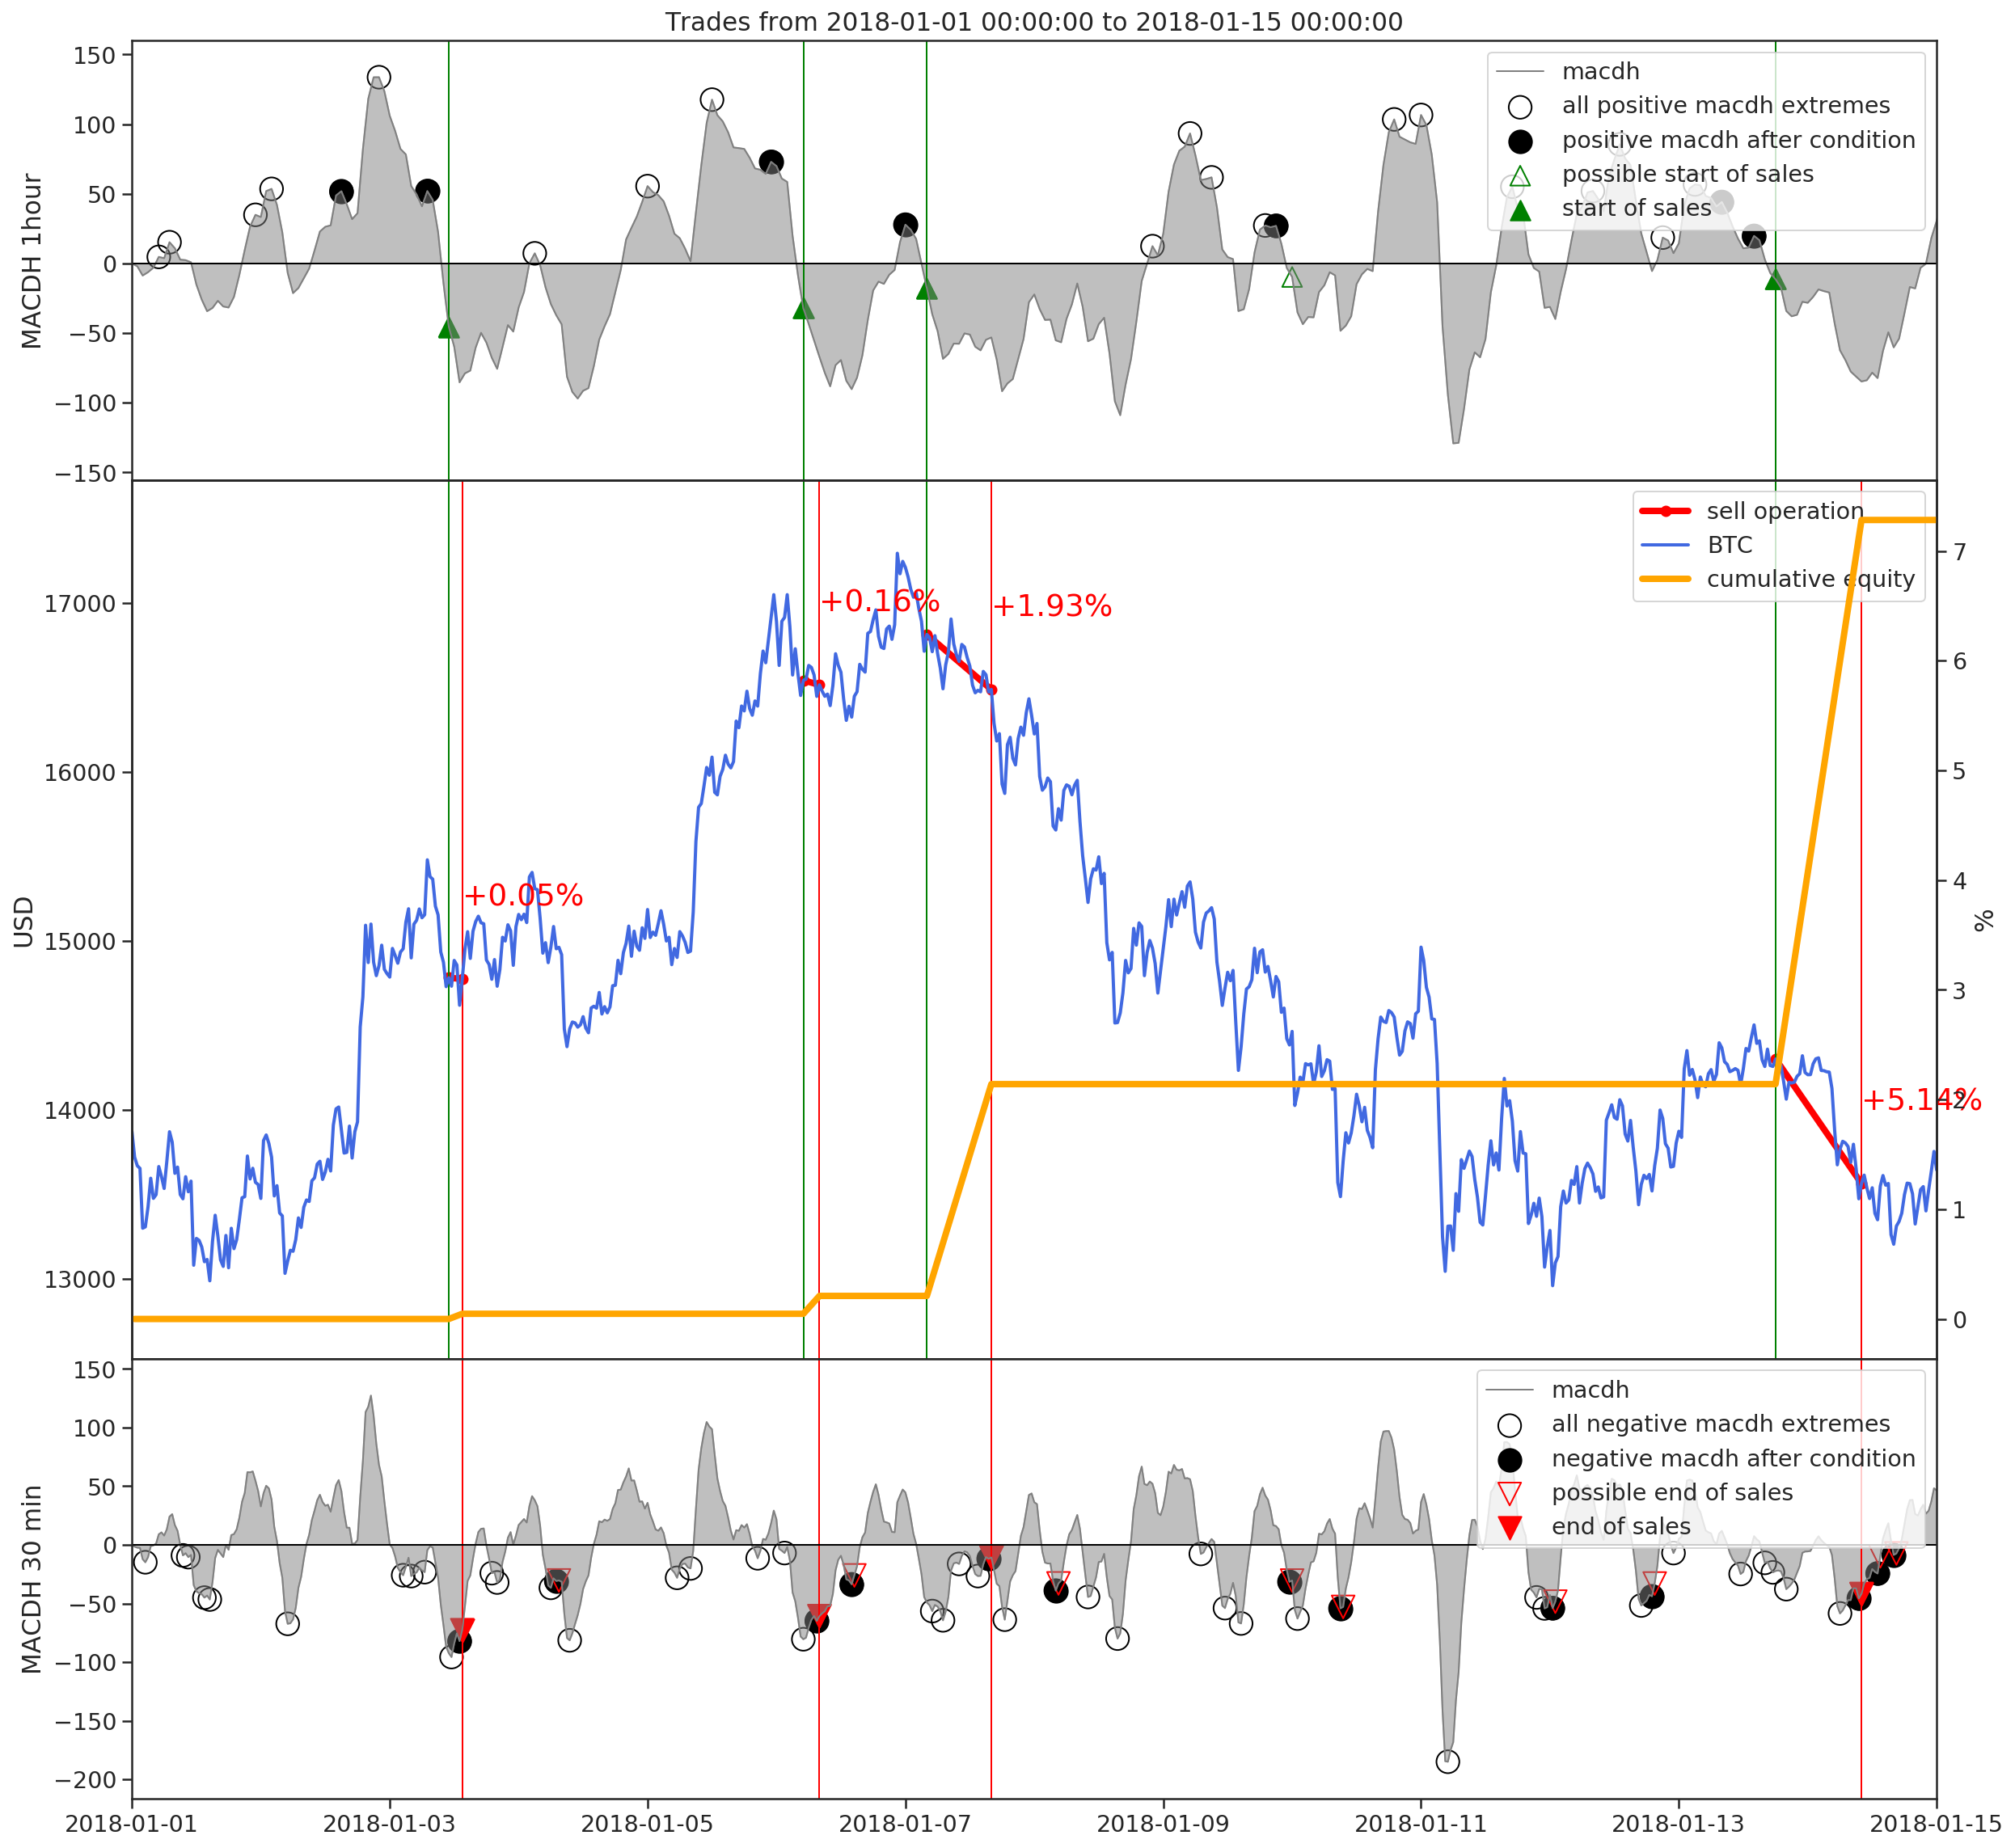

In [1811]:
drow_grafics(stock, stock_1h, deal_points, test_period)

In [1812]:
def make_result_and_save(stock, deal_points):
    
    # drow full cumulative equity
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    lns1 = ax.plot(stock.index, stock['close'], linewidth=1, color='royalblue', label = 'BTC')
    plt.ylabel('USD')
    ax2 = ax.twinx()
    plt.ylabel('%')
    lns2 = ax2.plot(stock.index, stock['cumulative_equity'],\
                    color='orange', linewidth=2, label = 'Cumulative equity')
    
    plt.title(f'Equity from {stock.index[0]} to {stock.index[-1]}')
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax.set_xlim(stock.index[0],stock.index[-1])
    ax.legend(lns, labs, loc='upper center')
        
    # calculate metrics
    metrics =\
    [['Mean positive equity', round(deal_points[deal_points['equity']>=0]['equity'].mean(), 2)],
    ['Mean negative equity', round(deal_points[deal_points['equity']<0]['equity'].mean(), 2)],
    ['Count trades', len(deal_points)],
    ['Percent positive trades', round(len(deal_points[deal_points['equity']>=0]['equity'])/count_trades*100, 2)],
    ['Percent_negative trades', round(len(deal_points[deal_points['equity']<0]['equity'])/count_trades*100 , 2)],
    ['Pharpe ratio', round(deal_points['equity'].mean()/deal_points['equity'].std(), 2)],
    ['Result cumulative equity', round(stock[~np.isnan(stock['cumulative_equity'])]['cumulative_equity'][-1], 2)]]
    
    metrics_df = pd.DataFrame(metrics, columns=['Metric', 'Value'])
    
    # save data
    fig.savefig(f'Equity from {stock.index[0]} to {stock.index[-1]}.jpeg')
    metrics_df.to_excel(f'Metrics from {stock.index[0]} to {stock.index[-1]}.xlsx')
    deal_points.to_excel(f'Trades from {stock.index[0]} to {stock.index[-1]}.xlsx')
    
    return metrics_df

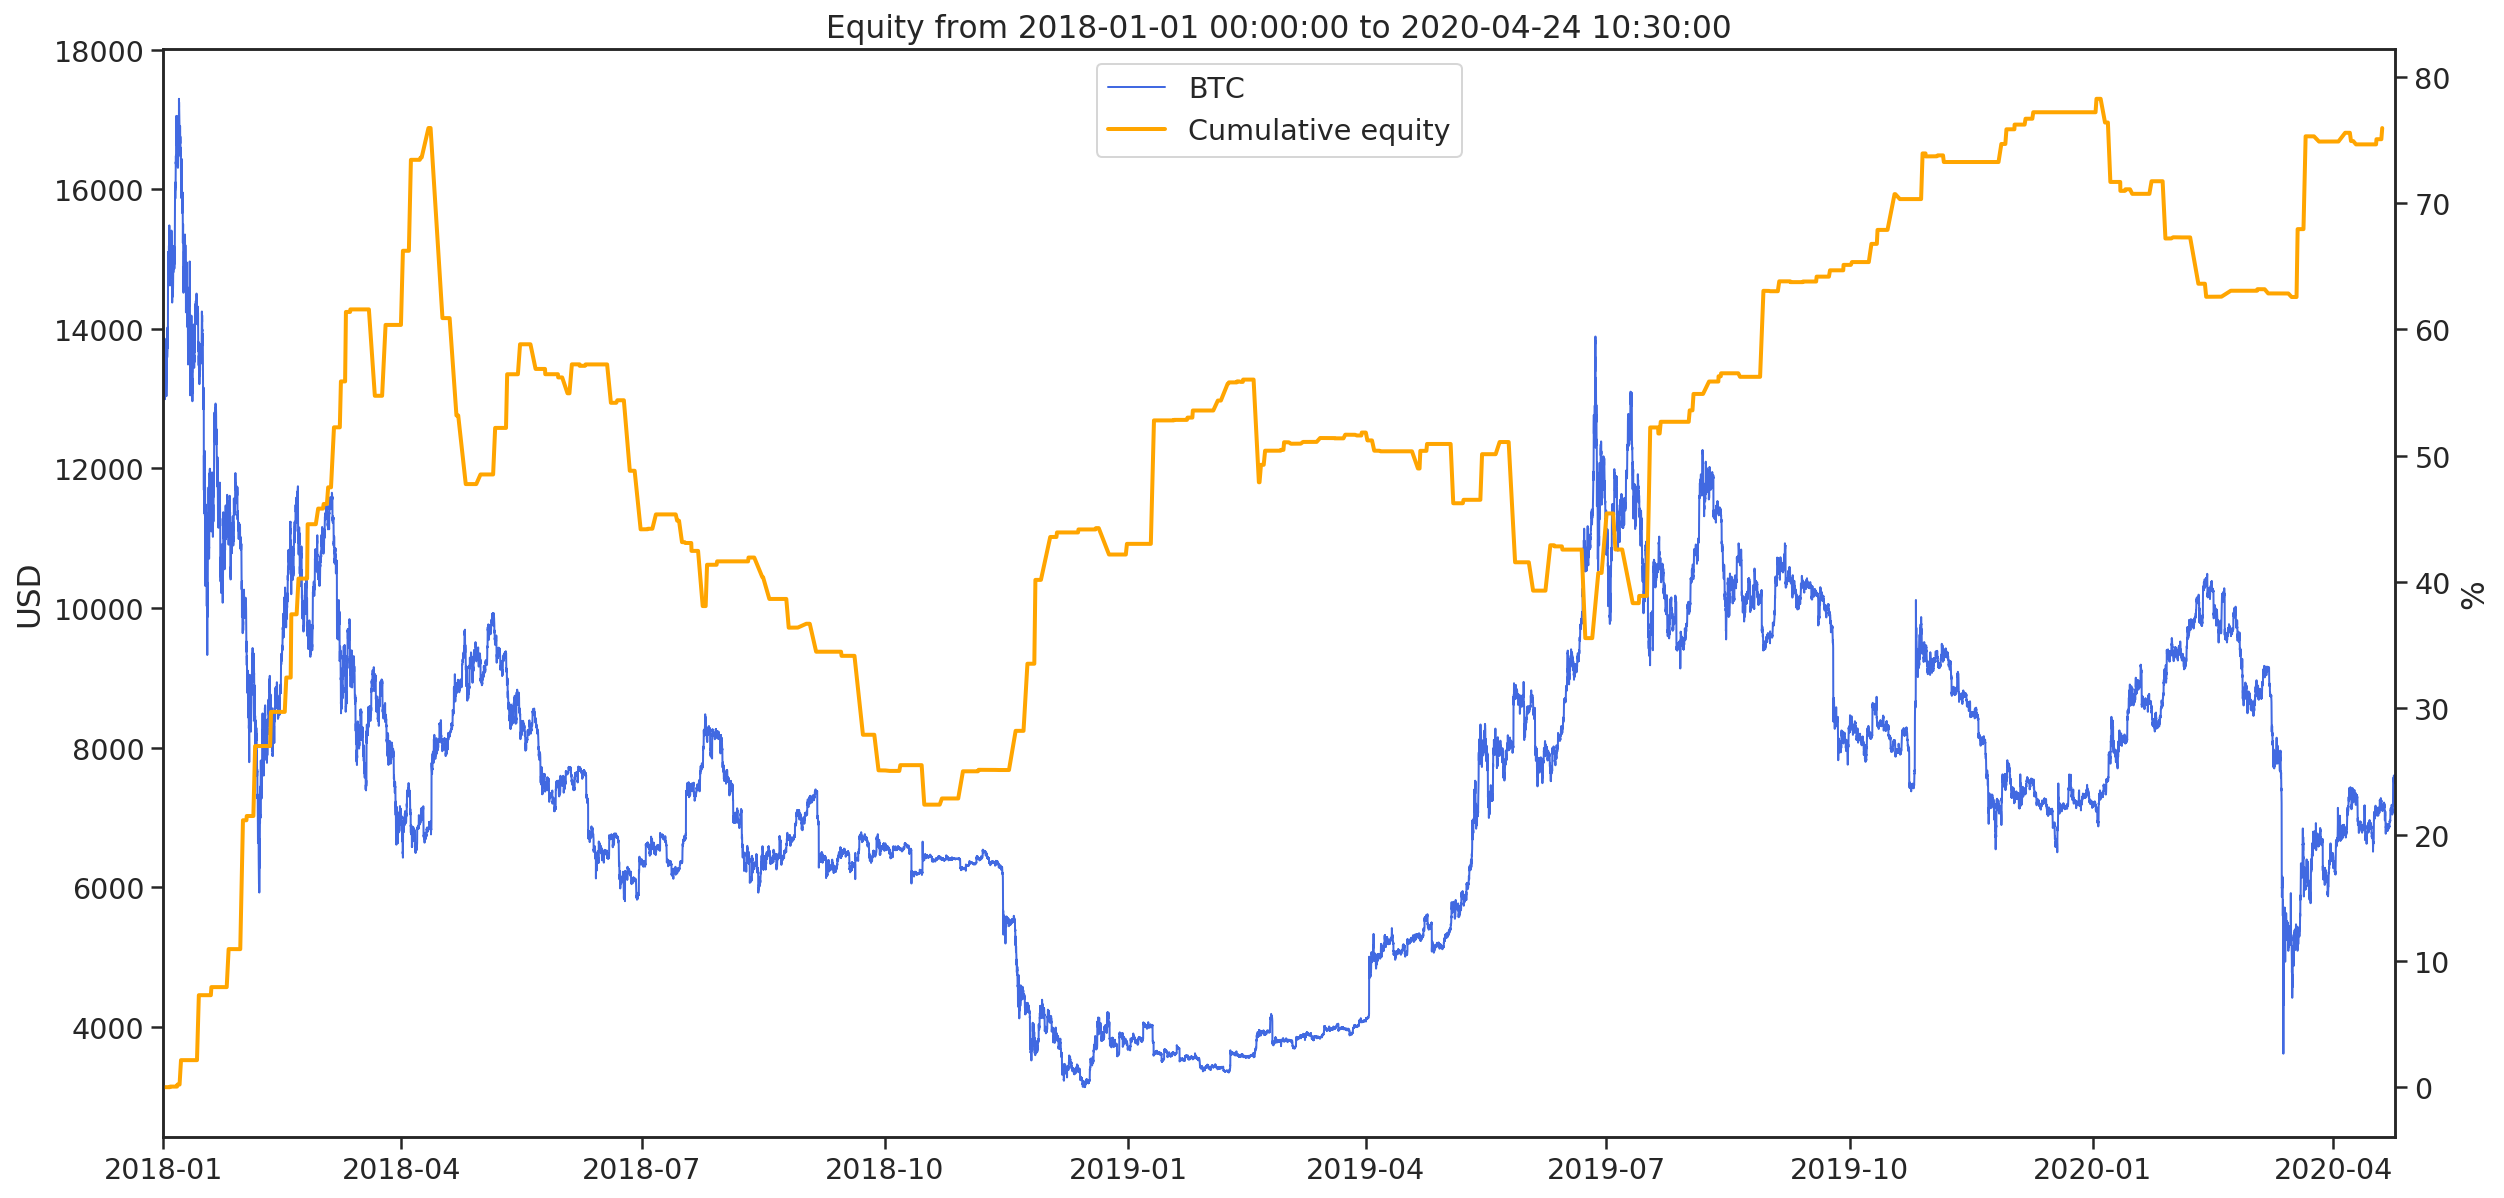

In [1813]:
metrics_df = make_result_and_save(stock, deal_points)

In [1814]:
metrics_df

,Metric,Value
0,Mean positive equity,1.97
1,Mean negative equity,-2.20
2,Count trades,180.00
3,Percent positive trades,63.33
4,Percent_negative trades,36.67
5,Pharpe ratio,0.13
6,Result cumulative equity,75.92
